In [ ]:
# ============================================================
# 📦 Imports
# ============================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  

In [2]:

# ============================================================
# ⚙️ Step 1: Setup Device
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

🚀 Using device: cuda


In [7]:

# ============================================================
# 📂 Step 2: Load Dataset
# ============================================================
data = pd.read_csv(r"C:\Users\dilip\datasets\Deep Learning 5th sem\lab expts\AirPassengers.csv")
print(data.head())
values = data['Passengers'].values.astype(float).reshape(-1, 1)

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


In [8]:

# ============================================================
# 🔢 Step 3: Normalize Data
# ============================================================
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

# ============================================================
# 🧩 Step 4: Create Sequences
# ============================================================
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 12  # lookback window
X, y = create_sequences(values, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# ============================================================
# 🧠 Step 5: Define Models
# ============================================================

# ---- Feedforward Neural Network ----
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten time dimension
        return self.fc(x)

# ---- Bidirectional RNN (LSTM) ----
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(BiRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # *2 for bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last timestep output
        return out

In [9]:

# ============================================================
# ⚡ Step 6: Initialize Models, Loss, Optimizers
# ============================================================
input_size = 1
hidden_size = 64
epochs = 50

fnn = FNN(input_size=SEQ_LEN).to(device)
birnn = BiRNN(input_size, hidden_size).to(device)

criterion = nn.MSELoss()
optimizer_fnn = optim.Adam(fnn.parameters(), lr=0.001)
optimizer_rnn = optim.Adam(birnn.parameters(), lr=0.001)

# ============================================================
# 🏋️ Step 7: Training Function
# ============================================================
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)

        train_losses.append(loss.item())
        test_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

    return train_losses, test_losses


Training Feedforward Neural Network...
Epoch [10/50] | Train Loss: 0.150934 | Val Loss: 0.439764
Epoch [20/50] | Train Loss: 0.064291 | Val Loss: 0.206212
Epoch [30/50] | Train Loss: 0.014517 | Val Loss: 0.048433
Epoch [40/50] | Train Loss: 0.011779 | Val Loss: 0.025370
Epoch [50/50] | Train Loss: 0.009773 | Val Loss: 0.022180

Training Bidirectional RNN (LSTM)...
Epoch [10/50] | Train Loss: 0.072297 | Val Loss: 0.309763
Epoch [20/50] | Train Loss: 0.026713 | Val Loss: 0.110268
Epoch [30/50] | Train Loss: 0.025679 | Val Loss: 0.103268
Epoch [40/50] | Train Loss: 0.024478 | Val Loss: 0.124147
Epoch [50/50] | Train Loss: 0.021343 | Val Loss: 0.083129


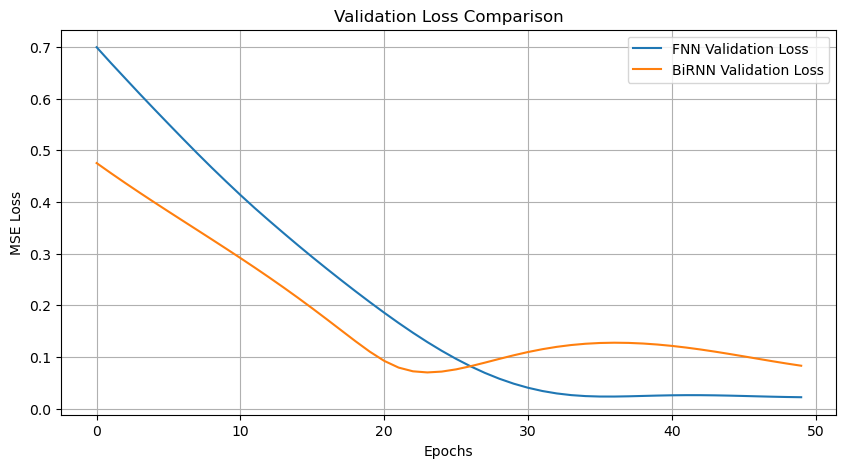

In [10]:

# ============================================================
# 🚀 Step 8: Train Both Models
# ============================================================
print("\nTraining Feedforward Neural Network...")
fnn_train_loss, fnn_val_loss = train_model(fnn, optimizer_fnn, criterion, X_train, y_train, X_test, y_test, epochs)

print("\nTraining Bidirectional RNN (LSTM)...")
rnn_train_loss, rnn_val_loss = train_model(birnn, optimizer_rnn, criterion, X_train, y_train, X_test, y_test, epochs)

# ============================================================
# 📊 Step 9: Compare Training Performance
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(fnn_val_loss, label='FNN Validation Loss')
plt.plot(rnn_val_loss, label='BiRNN Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

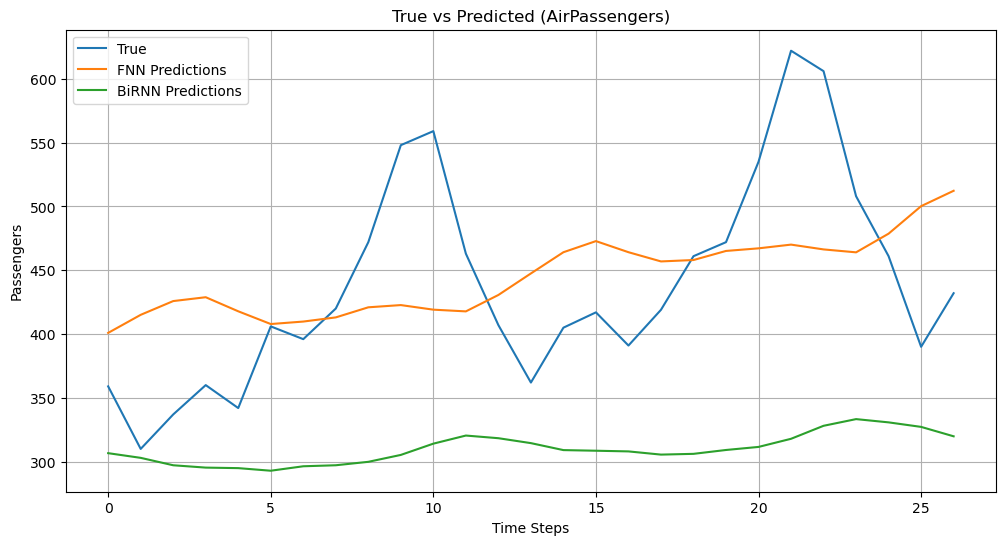

In [11]:

# ============================================================
# 🔮 Step 10: Evaluate and Visualize Predictions
# ============================================================
def predict(model, X):
    model.eval()
    with torch.no_grad():
        preds = model(X).cpu().numpy()
    return preds

fnn_preds = predict(fnn, X_test)
rnn_preds = predict(birnn, X_test)

# Inverse scale to original
fnn_preds_inv = scaler.inverse_transform(fnn_preds)
rnn_preds_inv = scaler.inverse_transform(rnn_preds)
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy())

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='True')
plt.plot(fnn_preds_inv, label='FNN Predictions')
plt.plot(rnn_preds_inv, label='BiRNN Predictions')
plt.title('True vs Predicted (AirPassengers)')
plt.xlabel('Time Steps')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()
